In [260]:
from collections import namedtuple
import itertools
import glob
import logging
import os
import random


import argparse
import numpy as np
import pydub
import tensorflow as tf

from audio_load import load_audio_from_files, audio2spec
from st_2d import scat2d
import windows as win

In [263]:
import importlib

In [264]:
importlib.reload(win)

<module 'windows' from '/cfarhomes/ilyak/ilyakavalerov@gmail.com/ramawks69/pyfst/windows.py'>

In [265]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

In [271]:
# cortical
winobj = win.cortical_psi_factory([4, 8, 16, 32], [.25, .5, 1, 2, 4, 8], 64)
print(winobj.nfilt)

48


In [267]:
# wavelet
winobj = win.tang_psi_factory(9, 9, [1,17,17])
winobj = win.winO(winobj.nfilt, winobj.filters.squeeze(), winobj.filter_params, winobj.kernel_size[1:])

In [268]:
from colorsys import hls_to_rgb

def make_color(M):
    return (M - M.min()) / (M.max() - M.min())

def colorize(z):
    # complex to color
    # https://stackoverflow.com/questions/17044052/mathplotlib-imshow-complex-2d-array/36082859
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c

In [269]:
# fst
winobj = win.fst2d_psi_factory([13, 13], include_avg=False)

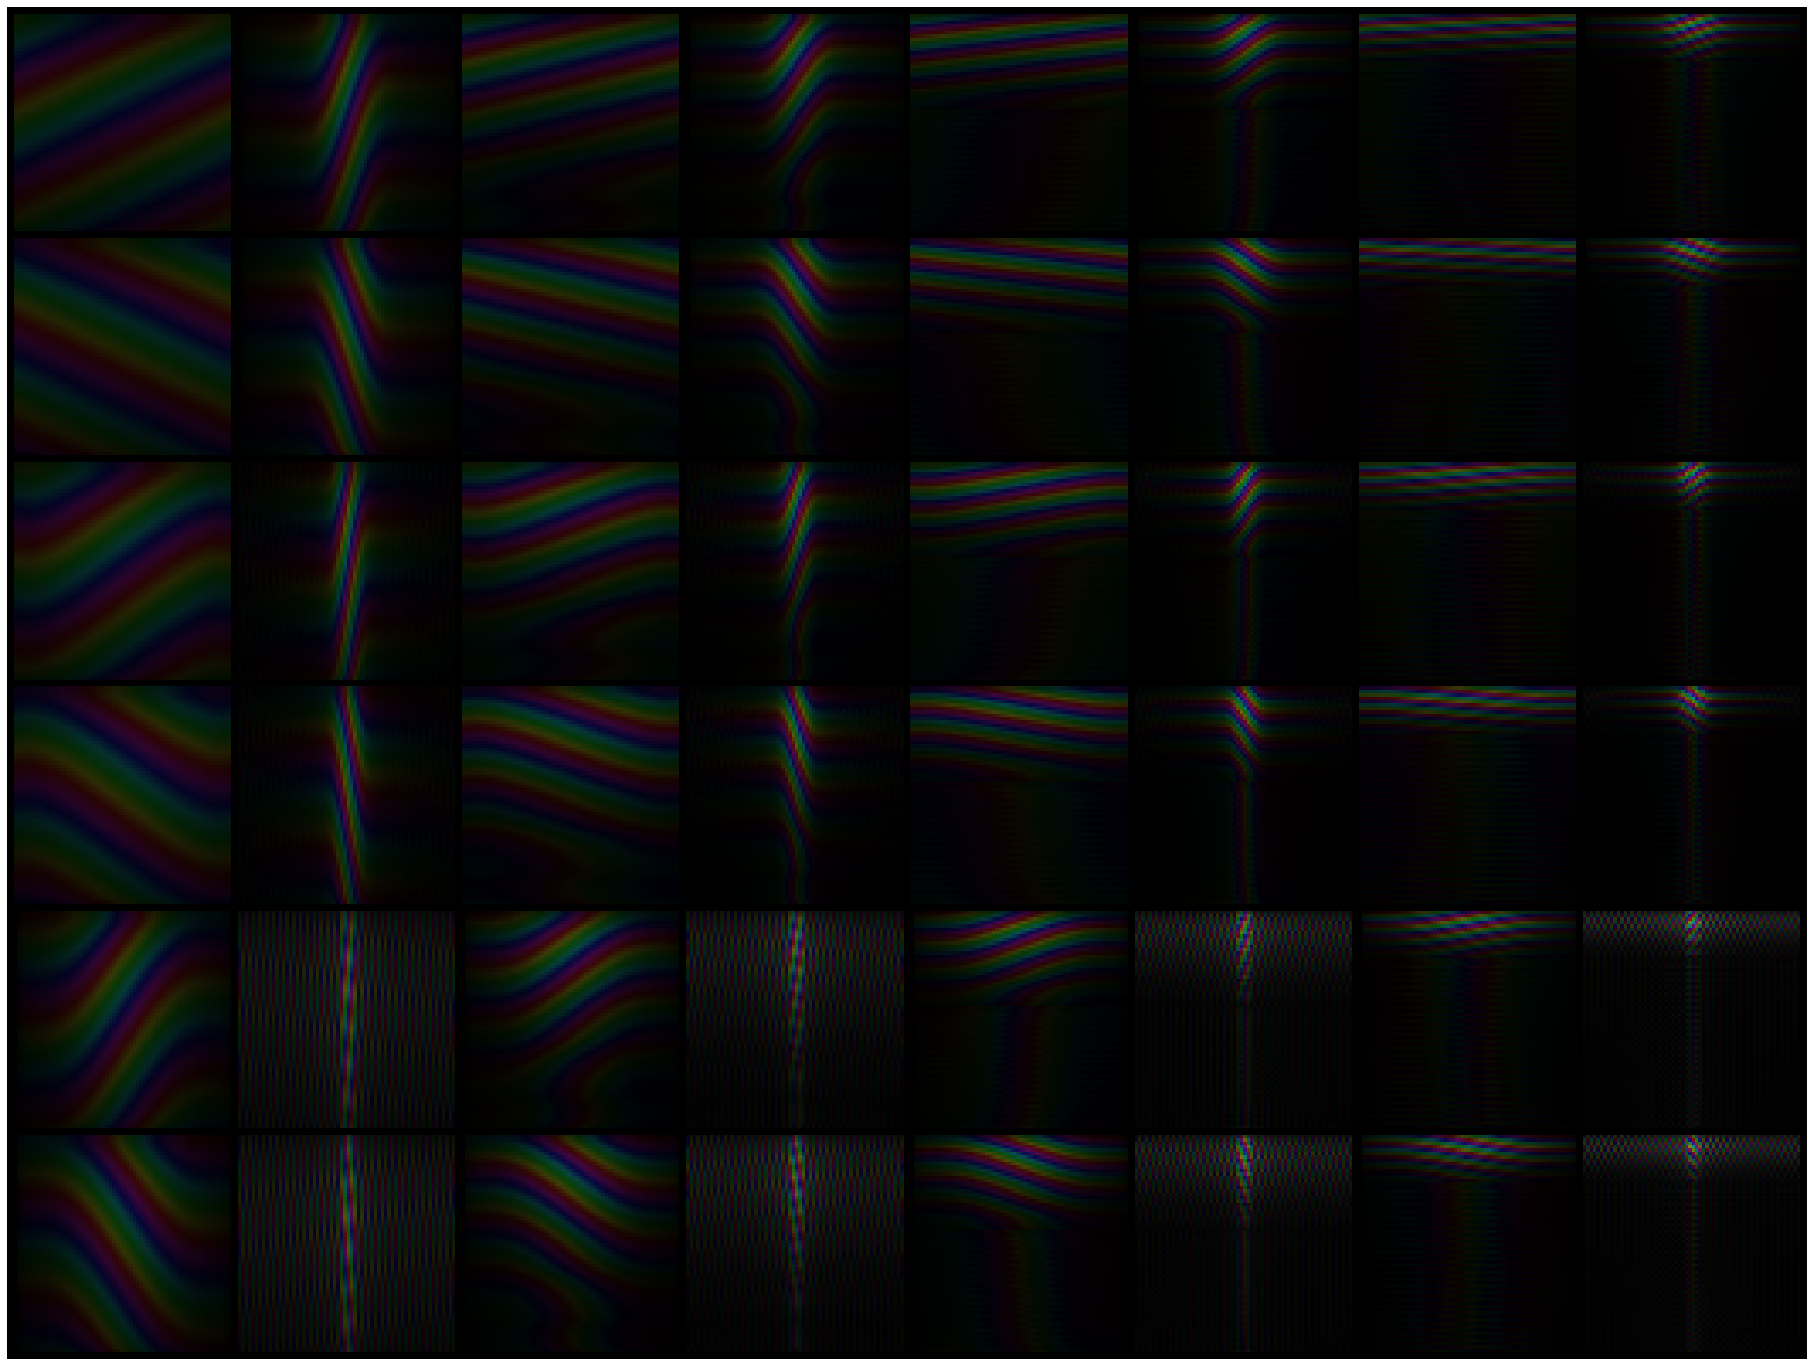

In [272]:

nrow = int(np.sqrt(winobj.nfilt))
leftover = winobj.nfilt % nrow
ncol = winobj.nfilt // nrow
if leftover:
    ncol += 1

img = np.zeros((2+(winobj.kernel_size[0]+2)*nrow, 2+((winobj.kernel_size[1]+2)*ncol), 3))
for col in range(ncol):
    for row in range(nrow):
        idx = col*nrow + row
        if idx < winobj.nfilt:
            filt_ = winobj.filters[:,:,idx]
            img[ (row*(winobj.kernel_size[0]+2)+2):((row+1)*(winobj.kernel_size[0]+2)), (col*(winobj.kernel_size[1]+2)+2):((col+1)*(winobj.kernel_size[1]+2)) ] = \
                colorize(filt_)

fig = plt.figure()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
fig.set_figheight(25)
fig.set_figwidth(25)
plt.imshow(img)

## Tensorflow

In [273]:
import tensorflow as tf
from st_2d import scat2d
import windows as win
layerO = namedtuple('layerO', ['strides', 'padding'])

### Load data

In [274]:
tfrecord_file = '/scratch1/ilya/locDoc/data/alexa/v6cx2/train_80000/_clean_speech_00_0000.tfrecord'

In [275]:
spec_h = 256 # 80
examples = []
specs = []
spec_labs = []
audio_labs = []
limit = 100

for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)

    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec_labs.append(eg_np.features.feature["spectrogram_label"].int64_list.value)
    audio_labs.append(eg_np.features.feature["audio_label"].int64_list.value)
    spec = np.array(spec).reshape(spec_h,-1)
    specs.append(spec)
    if i > limit:
        break
spec_labs = np.array(spec_labs)

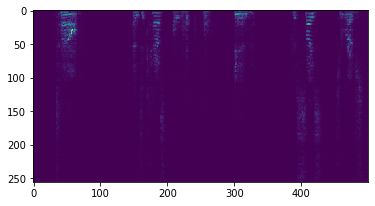

In [276]:
plt.imshow(specs[0])

## CPU convolution

In [277]:
from scipy.signal import convolve2d

In [278]:
res = convolve2d(specs[0], (gen_cor(4, 2, 1, 32)))

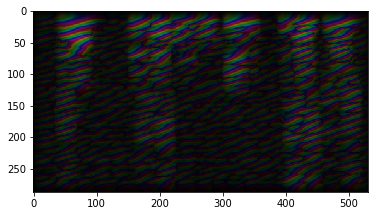

In [279]:
plt.imshow(colorize(res.T))

## Tensorflow

In [215]:
# sz = 13
# psi = win.fst2d_psi_factory([sz, sz], include_avg=False)
# layer_params = layerO((1,1), 'same')

In [280]:
rv = [4, 8, 16, 32]
sv = [.25, .5, 1, 2, 4, 8]
psi = gen_cor_bank(rv, sv, 32)
nrate = len(rv)
nscale = 2*len(sv)
layer_params = layerO((1,1), 'same')

In [281]:
psi.filters.shape

(32, 32, 48)

In [282]:
# define the operations
input_spec = tf.placeholder(tf.float32, shape=(2,256,500))
x = tf.expand_dims(input_spec, -1) # batch, freq, time, 1

U1 = scat2d(x, psi, layer_params)
h = U1.shape[1]
w = U1.shape[2]
### bs, h, w, time varying, frequency varying
U1 = tf.reshape(U1, [-1, h, w, nrate, nscale])
### bs, time varying, frequency varying, h, w
U1 = tf.transpose(U1, [0,3,4,1,2])

# rategram is max over scale varying
rategram = tf.layers.max_pooling3d(U1, (1,nscale,1), (1,nscale,1), padding='same')
rategram = tf.reshape(rategram, [-1, nrate, h, w])
# scalegram is max over rate varying
scalegram = tf.layers.max_pooling3d(U1, (nrate,1,1), (nrate,1,1), padding='same')
scalegram = tf.reshape(scalegram, [-1, nscale, h, w])

cortical = tf.concat([rategram, scalegram], axis=1)
cortical = tf.transpose(cortical, [0,2,3,1])

In [283]:
cortical.shape

TensorShape([Dimension(2), Dimension(256), Dimension(500), Dimension(16)])

In [284]:
sess = tf.Session()

In [285]:
sess.run(tf.global_variables_initializer())

In [286]:
feed_dict = {input_spec: specs[0:2]}

In [287]:
cortical_np = sess.run(cortical, feed_dict)

In [288]:
cortical_np.shape

(2, 256, 500, 16)

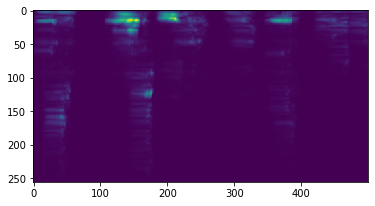

In [299]:
plt.imshow(cortical_np[1,:,:,13])